In [1]:
from generate_data import wave_util
from generate_data import wave_propagation
import torch
import numpy as np
import matplotlib.pyplot as plt
from models import model_end_to_end
from models import model_unet
from skimage.transform import resize
from generate_data import postprocess_wave
from models.model_utils import fetch_data_end_to_end

metrics to compare:
- speed in ms per delta t timestep (fine solver vs end to end) -> scale that to big resolution and say we save x amount of time
- MSE, MAE for each snapshot
- generalization (marmousi and bp dataset, but then own, easier velocities)

In [2]:
#params
boundary_c = 'absorbing'
dx = 2.0/128.0
dt = dx/20
dX = dx * 2
dT = dt * 4
delta_t_star = .06
T = .6
scaler = 2
n_snaps = 10
Nx,Ny = 128, 128
c_Nx, c_Ny = 64,64

path = "../data/end_to_end_bp_m_200_2000.npz"
loaders = fetch_data_end_to_end([path], shuffle=False, batch_size=1)

setting up data
test data points: 200


In [3]:
# set up models

restr_model1 = model_end_to_end.Restriction_nn(res_scaler = scaler,boundary_c=boundary_c, delta_t_star=delta_t_star, f_delta_x = dx).double()
restr_model1 = torch.nn.DataParallel(restr_model1)
restr_model1.load_state_dict(torch.load('../results/run_2/saved_model_end_to_end_unet128_14.pt'))
restr_model1.eval()

netlist = [
    (r'end-to-end unet 3lvl', restr_model1),
]

for netname,netmodl in netlist:
    model_parameters = filter(lambda p: p.requires_grad, netmodl.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(netname,'number of trainable parameters', params)

end-to-end unet 3lvl number of trainable parameters 44883


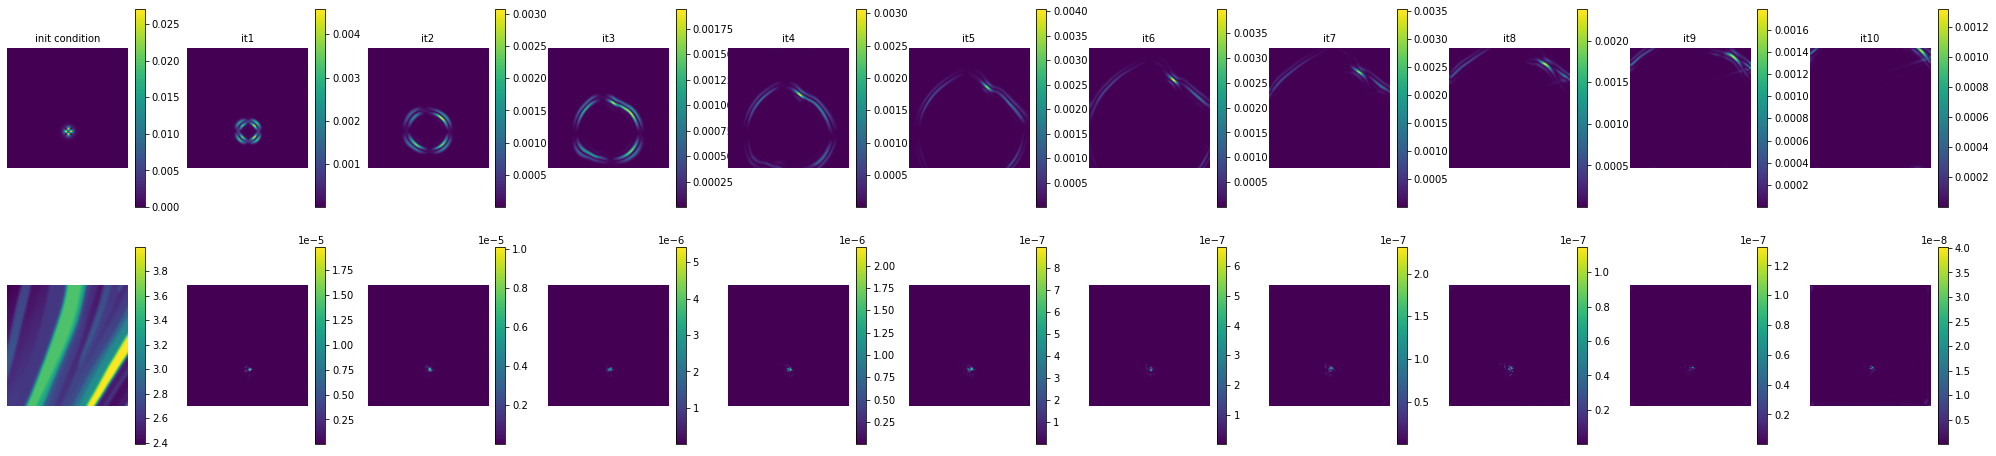

In [4]:
for loader in loaders:
    for i, data in enumerate(loader):

        input = data[0].squeeze() # n_snaps x 4 x w x h
        fig = plt.figure(figsize=(35,8))

        #initial condition visualization
        u_x, u_y, u_t_c, vel = input[0, 0, :, :], input[0, 1, :, :], input[0, 2, :, :], input[0, 3, :, :]
        sumv = torch.sum(torch.sum(u_x))
        u, ut = wave_util.WaveSol_from_EnergyComponent_tensor(u_x.unsqueeze(dim=0), u_y.unsqueeze(dim=0), u_t_c.unsqueeze(dim=0), vel.unsqueeze(dim=0), dx, sumv)

        ax2 = fig.add_subplot(2,11,1)
        pos2 = ax2.imshow(wave_util.WaveEnergyField_tensor(u.squeeze(),ut.squeeze(),vel,dx)*dx*dx)
        ax2.set_title('init condition', fontsize=10)
        plt.colorbar(pos2)
        plt.axis('off')

        # velocity visualization
        ax1 = fig.add_subplot(2,11,12)
        vel_img = input[0, 3, :, :]
        pos1 = ax1.imshow(vel_img)
        plt.colorbar(pos1)
        plt.axis('off')

        output = input[0, :3, :, :].unsqueeze(dim=0)

        for j in range(1,input.shape[0]):

            #fine solver iteration
            u_x, u_y, u_t_c, vel = input[j, 0, :, :], input[j, 1, :, :], input[j, 2, :, :], input[j, 3, :, :]
            sumv = torch.sum(torch.sum(u_x))
            u, ut = wave_util.WaveSol_from_EnergyComponent_tensor(u_x.unsqueeze(dim=0), u_y.unsqueeze(dim=0), u_t_c.unsqueeze(dim=0), vel.unsqueeze(dim=0), dx, sumv)

            ax = fig.add_subplot(2,11,1+j)
            pos = ax.imshow(wave_util.WaveEnergyField_tensor(u.squeeze(),ut.squeeze(),vel,dx)*dx*dx)
            ax.set_title('it'+str(j), fontsize=10)
            plt.colorbar(pos)
            plt.axis('off')

            #restr result
            output = torch.concat([output,vel_img.unsqueeze(0).unsqueeze(0)],dim=1)
            output = restr_model1(output)  # b x 3 x w x h
            u_x, u_y, u_t_c = output[:,0, :, :], output[:,1, :, :], output[:,2, :,:]
            sumv = torch.sum(torch.sum(u_x))
            u, ut = wave_util.WaveSol_from_EnergyComponent_tensor(u_x, u_y, u_t_c, vel, dt, sumv)

            ax2 = fig.add_subplot(2,11,12+j)
            pos2 = ax2.imshow(wave_util.WaveEnergyField_tensor(u.squeeze().detach(), ut.squeeze().detach(), vel, dx) * dx * dx)
            plt.colorbar(pos2)
            plt.axis('off')

        break
    break